# Abstract

(Just a sketch) Green's functions and their fourier transform are very useful entities, due to being directly measurable as physical quantities like the spectral function or the susceptibilty and being able to model complex many-body interactions using two-, three- and four-point functions. Due to these calculations being very costly, an intermediate representation of the Green's functions between matsubara frequency and time domain was developed. An advantage of this is a fast and efficient way to retrieve both function variants. This work compares several simpler approaches to geth the Fourier transform to the one using intermediate representations for two- and three-point functions. Afterwards, it is applied in a practical example.


# Introduction

The code for this work is written in Julia, using the library Fermions.jl. it models concepts for the second quantization like Fock-spaces, operators, solvers and much more for fermionic particles. First, four basic libraries are imported.

In [1]:
using Fermions
using LinearAlgebra
using Fermions.Aux
using Plots

# Three-Point Propagator Function

In [2]:
function G_ABC_n_ord_Lehmann1(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,B::Operator,
    C::Operator,n::Array{Complex{T},1}, τ1::Array{T,1},τ2::Array{T,1},β::Real) where T <: Real
    val_arr = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(τ1), j in 1:length(τ2)
        if τ1[i] >= τ2[j]
            val_arr[i,j] = 0 + 0im
            for m in 1:length(ϵ), s in 1:length(ϵ)
                val_arr[i,j] += dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*Ψn[:,s])*
                dot(Ψn[:,s],C*n)*exp(-ϵ[m]*(τ1[i]-τ2[j])-ϵ[s]*τ2[j])
            end
            val_arr[i,j] *= exp(-ϵ_n*(β-τ1[i]))
        else #τ2 > τ1
            val_arr[i,j] = 0 + 0im
            for m in 1:length(ϵ), s in 1:length(ϵ)
                val_arr[i,j] += dot(n,B*Ψn[:,m])*dot(Ψn[:,m],A*Ψn[:,s])*
                dot(Ψn[:,s],C*n)*exp(-ϵ[m]*(τ2[j]-τ1[i])-ϵ[s]*τ1[i])
            end
            if wick_parity(A) * wick_parity(B) == 1 #two fermionic Operators
                val_arr[i,j] *= -1.0*exp(-ϵ_n*(β-τ2[j]))
            else
                val_arr[i,j] *= exp(-ϵ_n*(β-τ2[j]))
            end
        end
    end
    return val_arr
end

function G_ABC_Lehmann1(A::Operator, B::Operator,C::Operator, τ1::Array{T,1},
    τ2::Array{T,1},H::Operator,β::Real) where T <: Real
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    result = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(H_eigene)
        if i == 1
            result=G_ABC_n_ord_Lehmann1(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],τ1,τ2,β)
        else
            result=result .+ G_ABC_n_ord_Lehmann1(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],τ1,τ2,β)
        end
        Z += exp(-β*H_eigene[i])
    end
    result = -1.0 .* result ./ Z
    return result
end

G_ABC_Lehmann1 (generic function with 1 method)

We reuse this code for our representation of the analytically transformed Lehmann representation:

In [3]:
function G_ABC_n_ord_Lehmann(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,B::Operator,
    C::Operator,n::Array{Complex{T},1}, ω1::Array{T,1},ω2::Array{T,1},β::Real) where T <: Real
    val_arr1 = zeros(length(ω1),length(ω2)) .+ 0im
    for i in 1:length(ω1), j in 1:length(ω2)

        val_arr1[i,j] = 0 + 0im
        for m in 1:length(ϵ), s in 1:length(ϵ)
            product = dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*Ψn[:,s])*dot(Ψn[:,s],C*n)* (1/(ϵ[s]-ϵ[m]-im*ω2[j]))
            if (ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]) == 0
                sometimes_zero_term = -β
            else
                sometimes_zero_term = 1/(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j])*(exp(-β*(ϵ[s]-ϵ_n))-1)
            end
            
            product = product * (sometimes_zero_term+1/(ϵ[m]-ϵ_n-im*ω1[i])*(exp(-β*(ϵ[m]-ϵ_n))+1))
            val_arr1[i,j] += product
            #*exp(-ϵ[m]*(τ1[i]-τ2[j])-ϵ[s]*τ2[j])
        end
        val_arr1[i,j] *= exp(-ϵ_n*β)
    end
    val_arr2 = zeros(length(ω1),length(ω2)) .+ 0im
    for i in 1:length(ω1), j in 1:length(ω2)
        
        val_arr2[i,j] = 0 + 0im
        for m in 1:length(ϵ), s in 1:length(ϵ)
            product = dot(n,B*Ψn[:,m])*dot(Ψn[:,m],A*Ψn[:,s])*dot(Ψn[:,s],C*n)* (1/(ϵ[s]-ϵ[m]-im*ω1[i])) 
            if (ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]) == 0
                sometimes_zero_term = -β
            else
                sometimes_zero_term = 1/(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j])*(exp(-β*(ϵ[s]-ϵ_n))-1)
            end
            
            product = product * (sometimes_zero_term+1/(ϵ[m]-ϵ_n-im*ω2[j]) * (exp(-β*(ϵ[m]-ϵ_n))+1))
            val_arr2[i,j] += product
            #*exp(-ϵ[m]*(τ2[j]-τ1[i])-ϵ[s]*τ1[i])
        end
        if wick_parity(A) * wick_parity(B) == 1 #two fermionic Operators
            val_arr2[i,j] *= -1.0*exp(-ϵ_n*β)
        else
            val_arr2[i,j] *= exp(-ϵ_n*β)
        end
    end
    return val_arr1+val_arr2
end

function G_ABC_Lehmann(A::Operator, B::Operator,C::Operator, τ1::Array{T,1},
    τ2::Array{T,1},H::Operator,β::Real, n_max1::Integer, n_max2::Integer) where T <: Real
    
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    result = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(H_eigene)
        if i == 1
            result=G_ABC_n_ord_Lehmann(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        else
            result=result .+ G_ABC_n_ord_Lehmann(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        end
        Z += exp(-β*H_eigene[i])
    end
    result = -1.0 .* result ./ Z
    return result
end

G_ABC_Lehmann (generic function with 1 method)

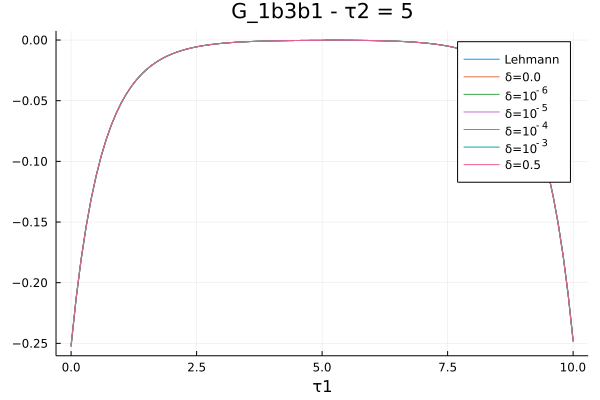

In [4]:
space3 = FockSpace(4)
c3 = annihilators(space3)
H3 = Hubbard(space3,3.,-1.,1.5)
β3 = 10.
A3 = Operator(space3)
A3 += 1.0 * c3[1]
B3 = Operator(space3)
B3 += 1.0 * c3[3]'*c3[3]
C3 = Operator(space3)
C3 += 1.0 * c3[1]'
τ1_arr = [0.0]
τ2_arr = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
for i in 1:100
    push!(τ1_arr,i/10)
end
G_1b3b1_Lehmann = real(G_ABC_Lehmann1(A3,B3,C3,τ1_arr,τ2_arr,H3,β3)[:,:])
G_1b3b1_00 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.0)[:,:])
G_1b3b1_0000001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.000001)[:,:])
G_1b3b1_000001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.00001)[:,:])
G_1b3b1_00001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.0001)[:,:])
G_1b3b1_0001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.001)[:,:])
G_1b3b1_05 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.5)[:,:])
plot(τ1_arr,[G_1b3b1_Lehmann[:,6],G_1b3b1_00[:,6],G_1b3b1_0000001[:,6],G_1b3b1_000001[:,6],G_1b3b1_00001[:,6],G_1b3b1_0001[:,6],G_1b3b1_05[:,6]],title = "G_1b3b1 - τ2 = 5", label = ["Lehmann" "δ=0.0" "δ=10^{-6}" "δ=10^{-5}" "δ=10^{-4}" "δ=10^{-3}" "δ=0.5"], lw = 1, xlabel = "τ1",fmt = :png)


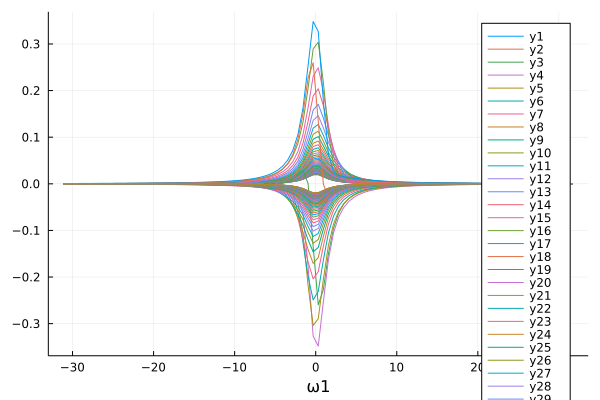

In [5]:
n_max3 = 50
n_max = n_max3
n3 = collect(-n_max:1:n_max)
n=n3
β = β3
ω3 = (2n.+1)*π/β

lehmann3 = G_ABC_Lehmann(A3,B3,C3,τ1_arr,τ2_arr,H3,β3, n_max3, n_max3)[:,:]
transform3_Lehmann = imag(lehmann3)
transform3_Lehmann_real = real(lehmann3)

plot(ω3, transform3_Lehmann, lw = 1, xlabel = "ω1",fmt = :png)

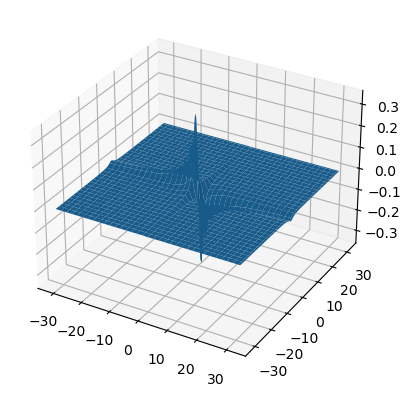

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x000000004E983340>

In [6]:
using PyPlot;
surf(ω3, ω3, transform3_Lehmann)

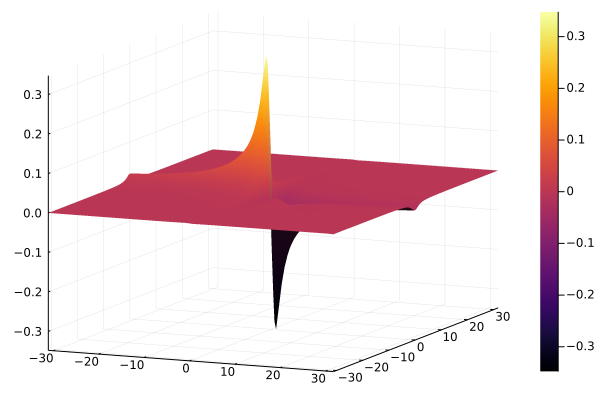

In [32]:
plot(ω3, ω3, transform3_Lehmann, st=:surface)

Again: Integral as a Sum

\begin{align}
    G(i \omega_{\nu}, \omega_{\mu}) \approx \sum_{l} \sum_{j} e^{i \omega_{\nu} \tau_l} e^{i \omega_{\mu} \tau_j} G(\tau_l, \tau_j) * \Delta \tau_j \Delta \tau_l
\end{align}

In [8]:
# goal 1 again
function G_ABC_transform(A, B, C, τ_arr1, τ_arr2, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    Δτ1 = (β/size(τ_arr1)[1])
    Δτ2 = (β/size(τ_arr2)[1])
    
    matrix1 = ℯ.^(im*ω1*transpose(τ_arr1))
    result = Δτ1*matrix1*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)
    
    matrix2 = ℯ.^(im*ω2*transpose(τ_arr2))
    result = Δτ2*matrix2*transpose(result)
    return transpose(result)
end


function G_ABC_transform_saved(G_THREE, τ_arr1, τ_arr2, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    dimtau1 = size(τ_arr1)[1]
    dimtau2 = size(τ_arr2)[1]
    dimG1 = size(G_THREE)[1]
    dimG2 = size(G_THREE)[2]  
    stepsizet1 = max(trunc(Int,dimG1/dimtau1),1)
    stepsizet2 = max(trunc(Int,dimG2/dimtau2),1)
    stepsizeinv1 = max(trunc(Int,dimtau1/dimG1),1)
    stepsizeinv2 = max(trunc(Int,dimtau2/dimG2),1)
    
    Δτ1 = (β/size(τ_arr1[begin:stepsizeinv1:end])[1])
    Δτ2 = (β/size(τ_arr2[begin:stepsizeinv2:end])[1])
    matrix1 = ℯ.^(im*ω1*transpose(τ_arr1[begin:stepsizeinv1:end]))
    result = Δτ1*matrix1*G_THREE[begin:stepsizet1:end,begin:stepsizet2:end]
    matrix2 = ℯ.^(im*ω2*transpose(τ_arr2[begin:stepsizeinv2:end]))
    result = Δτ2*matrix2*transpose(result)
    #println((Δτ1))
    #println(size(matrix1))
    #println(size(G_THREE[begin:stepsizet1:end,begin:stepsizet2:end]))
    #println(size(result))
    return transpose(result)
end

G_ABC_transform_saved (generic function with 1 method)

In [9]:
# make delta tau smaller!
τ_arr = collect(0.:0.01:β-0.01)

##greenfunction3 = G_ABC(A3,B3,C3,τ_arr,τ_arr,H3,β3,space3,0.0)
transform3 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))

plot(ω,transform3,
    title = "Transform", 
    label = ["transform"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)

LoadError: UndefVarError: greenfunction3 not defined

In [10]:
surf(ω3, ω3, transform3)

LoadError: UndefVarError: transform3 not defined

plot(ω3, ω3, transform3_Lehmann, st=:surface)

In [11]:
plot(ω3, ω3, transform3, st=:surface)



LoadError: UndefVarError: transform3 not defined

In [12]:
τ_arr = collect(0.:0.001:β-0.001)

##greenfunction3 = G_ABC(A3,B3,C3,τ_arr,τ_arr,H3,β3,space3,0.0)
   





10000-element Vector{Float64}:
 0.0
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01
 0.011
 0.012
 ⋮
 9.988
 9.989
 9.99
 9.991
 9.992
 9.993
 9.994
 9.995
 9.996
 9.997
 9.998
 9.999

In [13]:

τ_arr = collect(0.:0.1:β-0.1)
transform3_0_1 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))
τ_arr = collect(0.:0.05:β-0.05)
transform3_0_05 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))
τ_arr = collect(0.:0.01:β-0.01)
transform3_0_01 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))
τ_arr = collect(0.:0.001:β-0.001)
transform3_0_001 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))


τ_arr = collect(0.:0.001:β-0.001)
transform3_0_001_real = real(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))

x_cut = 25

plot(ω3, transform3_0_1[x_cut,:], label = ["100 points"])
plot!(ω3, transform3_0_05[x_cut,:], label = ["200 points"])
plot!(ω3, transform3_0_01[x_cut,:], label = ["1000 points"])
#plot!(ω3, transform3_0_001[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann[x_cut,:], label = ["analytical"])

println(size(transform3_Lehmann))

LoadError: UndefVarError: greenfunction3 not defined

## 

In [14]:
x_cut = 1

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [15]:
x_cut = 25

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [16]:
x_cut = 50

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [17]:
x_cut = 75

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [18]:
x_cut = 100

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [19]:
println(ω3[1])
println(ω3[25])
println(ω3[50])
println(ω3[75])
println(ω3[100])

-31.101767270538954
-16.022122533307943
-0.3141592653589793
15.393804002589984
31.101767270538954


In [20]:
plot(ω3, ω3, transform3_0_001, st=:surface)

LoadError: UndefVarError: transform3_0_001 not defined

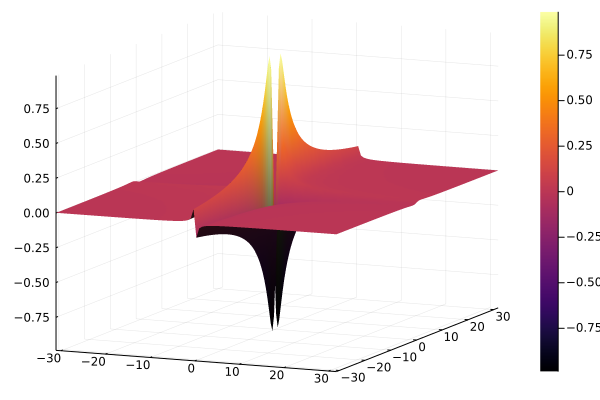

In [39]:
plot(ω3, ω3, transform3_Lehmann_real, st=:surface)

Goal 2: Integral with Gauss-Legendre but 2D, something like:

\begin{align}
    G(i \omega_n) \approx \sum_{j} \omega_j e^{i \omega_n \tau_j} G(\tau_j) \Delta \tau
\end{align}

In [22]:
# goal 2
#using QuadGK

#function G_AB_gl_part(A, B, H, β, space, ω_j)
#    f(x)=(ℯ.^(im*ω_j*x)*(G_AB(A,B,[x],H,β,space,0.0)))
#    return quadgk(f, 0, β, rtol=1e-2)
#end
#
#function G_AB_gl_transform(A, B, H, β, space, n_max)
#    n = collect(-n_max:1:n_max)
#    ω = (2n.+1)*π/β
#
#    result = []
#    for ω_j in ω
#        I, w = G_AB_gl_part(A, B, H, β, space, ω_j)
#        append!(result,I)
#    end
#    return result
#end

using Cuba, SpecialFunctions

function G_ABC_gl_part(A, B, C, H, β, space, ω1, ω2)
    #return transpose(Δτ2*ℯ.^(im*ω2*transpose(τ_arr2))*transpose(Δτ1*ℯ.^(im*ω1*transpose(τ_arr1))*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)))
    function integrand(x, f)
        #temp=transpose(ℯ.^(im*ω2*transpose(x[2]*β))*transpose(ℯ.^(im*ω1*transpose(x[1]*β))
        #        *G_ABC(A,B,C,[x[1]*β],[x[2]*β],H,β,space,0.0)[1,1]))
        temp=ℯ.^(im*ω2*(x[2]*β))*ℯ.^(im*ω1*(x[1]*β))*G_ABC(A,B,C,[x[1]*β],[x[2]*β],H,β,space,0.05)[1,1]
        #temp=1
        f[1],f[2]=reim(temp)
        #f[1]=im*x[1]
    end
    #result, err = cuhre(integrand, 2, 2, atol=1e-12, rtol=1e-10);
    result, err = cuhre(integrand, 2, 2, atol=1e-3, rtol=1e-2);
    return complex(result[1],result[2])
end

function G_ABC_gl_transform(A, B, C, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    τ_arr_expl = collect(0.:0.01:β-0.01)

    result = Array{typeof(zero(ComplexF64)), 2}(undef,length(ω1),length(ω2)) 
    for j in 1:length(ω1)
        for k in 1:length(ω2)    
            I = G_ABC_gl_part(A, B, C, H, β, space, ω1[j], ω2[k])
            #I=4
            println("Done with ", j, ", ", k)
            result[j,k] = I
        end
    end
    
    return result
end

#function G_ABC_gl_part_tau1(A, B, C, H, β, space, ω1, ω2, τ_arr2)
    #return transpose(Δτ2*ℯ.^(im*ω2*transpose(τ_arr2))*transpose(Δτ1*ℯ.^(im*ω1*transpose(τ_arr1))*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)))
#    f(x)=transpose(ℯ.^(im*ω2*transpose(τ_arr2))*transpose(ℯ.^(im*ω1*transpose(x))*G_ABC(A,B,C,[x],τ_arr2,H,β,space,0.0)))
#    return quadgk(f, 0, β, rtol=rtoli)
#end

#function G_ABC_gl_part_tau2(A, B, C, H, β, space, ω1, ω2, τ_arr1)
    #return transpose(Δτ2*ℯ.^(im*ω2*transpose(τ_arr2))*transpose(Δτ1*ℯ.^(im*ω1*transpose(τ_arr1))*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)))
#    f(x)=transpose(ℯ.^(im*ω2*transpose(x))*transpose(ℯ.^(im*ω1*transpose(τ_arr1))*G_ABC(A,B,C,τ_arr1,[x],H,β,space,0.0)))
#    return quadgk(f, 0, β, rtol=rtoli)
#end


#function G_ABC_transform(A, B, C, τ_arr1, τ_arr2, H, β, space, n_max1, n_max2)
#    n1 = collect(-n_max1:1:n_max1)
#    ω1 = (2n1.+1)*π/β
#    
#    n2 = collect(-n_max2:1:n_max2)
#    ω2 = (2n2.+1)*π/β
#    
#    Δτ1 = (β/size(τ_arr1)[1])
#    Δτ2 = (β/size(τ_arr2)[1])
#    
#    matrix1 = ℯ.^(im*ω1*transpose(τ_arr1))
#    result = Δτ1*matrix1*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)
#    
#    matrix2 = ℯ.^(im*ω2*transpose(τ_arr2))
#    result = Δτ2*matrix2*transpose(result)
#    return transpose(result)
#end



G_ABC_gl_transform (generic function with 1 method)

τ_arr_expl = collect(0.:0.01:β-0.01)
#I, w = G_ABC_gl_part_tau1(A3, B3, C3, H3, β3, space3, ω3[1], ω3[1], τ_arr_expl)

typeof(I)
I
I[1]
typeof(zero(ComplexF64))
typeof(I[1])

In [23]:
    n2 = collect(-20:1:20)
    ω2 = (2n2.+1)*π/β
length(ω2)

41

In [24]:

using Cuba, SpecialFunctions

transform3_cuhre = (G_ABC_gl_transform(A3, B3, C3, H3, β3, space3, n_max3, n_max3))

transform3_cuhre_imag = imag(transform3_cuhre)

Done with 1, 1
Done with 1, 2
Done with 1, 3
Done with 1, 4
Done with 1, 5
Done with 1, 6
Done with 1, 7
Done with 1, 8
Done with 1, 9
Done with 1, 10
Done with 1, 11
Done with 1, 12
Done with 1, 13
Done with 1, 14
Done with 1, 15
Done with 1, 16
Done with 1, 17
Done with 1, 18
Done with 1, 19
Done with 1, 20
Done with 1, 21
Done with 1, 22
Done with 1, 23
Done with 1, 24
Done with 1, 25
Done with 1, 26
Done with 1, 27
Done with 1, 28
Done with 1, 29
Done with 1, 30
Done with 1, 31
Done with 1, 32
Done with 1, 33
Done with 1, 34
Done with 1, 35
Done with 1, 36
Done with 1, 37
Done with 1, 38
Done with 1, 39
Done with 1, 40
Done with 1, 41
Done with 1, 42
Done with 1, 43
Done with 1, 44
Done with 1, 45
Done with 1, 46
Done with 1, 47
Done with 1, 48
Done with 1, 49
Done with 1, 50
Done with 1, 51
Done with 1, 52
Done with 1, 53
Done with 1, 54
Done with 1, 55
Done with 1, 56
Done with 1, 57
Done with 1, 58
Done with 1, 59
Done with 1, 60
Done with 1, 61
Done with 1, 62
Done with 1, 63
D

Done with 7, 38
Done with 7, 39
Done with 7, 40
Done with 7, 41
Done with 7, 42
Done with 7, 43
Done with 7, 44
Done with 7, 45
Done with 7, 46
Done with 7, 47
Done with 7, 48
Done with 7, 49
Done with 7, 50
Done with 7, 51
Done with 7, 52
Done with 7, 53
Done with 7, 54
Done with 7, 55
Done with 7, 56
Done with 7, 57
Done with 7, 58
Done with 7, 59
Done with 7, 60
Done with 7, 61
Done with 7, 62
Done with 7, 63
Done with 7, 64
Done with 7, 65
Done with 7, 66
Done with 7, 67
Done with 7, 68
Done with 7, 69
Done with 7, 70
Done with 7, 71
Done with 7, 72
Done with 7, 73
Done with 7, 74
Done with 7, 75
Done with 7, 76
Done with 7, 77
Done with 7, 78
Done with 7, 79
Done with 7, 80
Done with 7, 81
Done with 7, 82
Done with 7, 83
Done with 7, 84
Done with 7, 85
Done with 7, 86
Done with 7, 87
Done with 7, 88
Done with 7, 89
Done with 7, 90
Done with 7, 91
Done with 7, 92
Done with 7, 93
Done with 7, 94
Done with 7, 95
Done with 7, 96
Done with 7, 97
Done with 7, 98
Done with 7, 99
Done wit

Done with 13, 53
Done with 13, 54
Done with 13, 55
Done with 13, 56
Done with 13, 57
Done with 13, 58
Done with 13, 59
Done with 13, 60
Done with 13, 61
Done with 13, 62
Done with 13, 63
Done with 13, 64
Done with 13, 65
Done with 13, 66
Done with 13, 67
Done with 13, 68
Done with 13, 69
Done with 13, 70
Done with 13, 71
Done with 13, 72
Done with 13, 73
Done with 13, 74
Done with 13, 75
Done with 13, 76
Done with 13, 77
Done with 13, 78
Done with 13, 79
Done with 13, 80
Done with 13, 81
Done with 13, 82
Done with 13, 83
Done with 13, 84
Done with 13, 85
Done with 13, 86
Done with 13, 87
Done with 13, 88
Done with 13, 89
Done with 13, 90
Done with 13, 91
Done with 13, 92
Done with 13, 93
Done with 13, 94
Done with 13, 95
Done with 13, 96
Done with 13, 97
Done with 13, 98
Done with 13, 99
Done with 13, 100
Done with 13, 101
Done with 14, 1
Done with 14, 2
Done with 14, 3
Done with 14, 4
Done with 14, 5
Done with 14, 6
Done with 14, 7
Done with 14, 8
Done with 14, 9
Done with 14, 10
Done

Done with 19, 52
Done with 19, 53
Done with 19, 54
Done with 19, 55
Done with 19, 56
Done with 19, 57
Done with 19, 58
Done with 19, 59
Done with 19, 60
Done with 19, 61
Done with 19, 62
Done with 19, 63
Done with 19, 64
Done with 19, 65
Done with 19, 66
Done with 19, 67
Done with 19, 68
Done with 19, 69
Done with 19, 70
Done with 19, 71
Done with 19, 72
Done with 19, 73
Done with 19, 74
Done with 19, 75
Done with 19, 76
Done with 19, 77
Done with 19, 78
Done with 19, 79
Done with 19, 80
Done with 19, 81
Done with 19, 82
Done with 19, 83
Done with 19, 84
Done with 19, 85
Done with 19, 86
Done with 19, 87
Done with 19, 88
Done with 19, 89
Done with 19, 90
Done with 19, 91
Done with 19, 92
Done with 19, 93
Done with 19, 94
Done with 19, 95
Done with 19, 96
Done with 19, 97
Done with 19, 98
Done with 19, 99
Done with 19, 100
Done with 19, 101
Done with 20, 1
Done with 20, 2
Done with 20, 3
Done with 20, 4
Done with 20, 5
Done with 20, 6
Done with 20, 7
Done with 20, 8
Done with 20, 9
Done

Done with 25, 51
Done with 25, 52
Done with 25, 53
Done with 25, 54
Done with 25, 55
Done with 25, 56
Done with 25, 57
Done with 25, 58
Done with 25, 59
Done with 25, 60
Done with 25, 61
Done with 25, 62
Done with 25, 63
Done with 25, 64
Done with 25, 65
Done with 25, 66
Done with 25, 67
Done with 25, 68
Done with 25, 69
Done with 25, 70
Done with 25, 71
Done with 25, 72
Done with 25, 73
Done with 25, 74
Done with 25, 75
Done with 25, 76
Done with 25, 77
Done with 25, 78
Done with 25, 79
Done with 25, 80
Done with 25, 81
Done with 25, 82
Done with 25, 83
Done with 25, 84
Done with 25, 85
Done with 25, 86
Done with 25, 87
Done with 25, 88
Done with 25, 89
Done with 25, 90
Done with 25, 91
Done with 25, 92
Done with 25, 93
Done with 25, 94
Done with 25, 95
Done with 25, 96
Done with 25, 97
Done with 25, 98
Done with 25, 99
Done with 25, 100
Done with 25, 101
Done with 26, 1
Done with 26, 2
Done with 26, 3
Done with 26, 4
Done with 26, 5
Done with 26, 6
Done with 26, 7
Done with 26, 8
Don

Done with 31, 50
Done with 31, 51
Done with 31, 52
Done with 31, 53
Done with 31, 54
Done with 31, 55
Done with 31, 56
Done with 31, 57
Done with 31, 58
Done with 31, 59
Done with 31, 60
Done with 31, 61
Done with 31, 62
Done with 31, 63
Done with 31, 64
Done with 31, 65
Done with 31, 66
Done with 31, 67
Done with 31, 68
Done with 31, 69
Done with 31, 70
Done with 31, 71
Done with 31, 72
Done with 31, 73
Done with 31, 74
Done with 31, 75
Done with 31, 76
Done with 31, 77
Done with 31, 78
Done with 31, 79
Done with 31, 80
Done with 31, 81
Done with 31, 82
Done with 31, 83
Done with 31, 84
Done with 31, 85
Done with 31, 86
Done with 31, 87
Done with 31, 88
Done with 31, 89
Done with 31, 90
Done with 31, 91
Done with 31, 92
Done with 31, 93
Done with 31, 94
Done with 31, 95
Done with 31, 96
Done with 31, 97
Done with 31, 98
Done with 31, 99
Done with 31, 100
Done with 31, 101
Done with 32, 1
Done with 32, 2
Done with 32, 3
Done with 32, 4
Done with 32, 5
Done with 32, 6
Done with 32, 7
Do

Done with 37, 49
Done with 37, 50
Done with 37, 51
Done with 37, 52
Done with 37, 53
Done with 37, 54
Done with 37, 55
Done with 37, 56
Done with 37, 57
Done with 37, 58
Done with 37, 59
Done with 37, 60
Done with 37, 61
Done with 37, 62
Done with 37, 63
Done with 37, 64
Done with 37, 65
Done with 37, 66
Done with 37, 67
Done with 37, 68
Done with 37, 69
Done with 37, 70
Done with 37, 71
Done with 37, 72
Done with 37, 73
Done with 37, 74
Done with 37, 75
Done with 37, 76
Done with 37, 77
Done with 37, 78
Done with 37, 79
Done with 37, 80
Done with 37, 81
Done with 37, 82
Done with 37, 83
Done with 37, 84
Done with 37, 85
Done with 37, 86
Done with 37, 87
Done with 37, 88
Done with 37, 89
Done with 37, 90
Done with 37, 91
Done with 37, 92
Done with 37, 93
Done with 37, 94
Done with 37, 95
Done with 37, 96
Done with 37, 97
Done with 37, 98
Done with 37, 99
Done with 37, 100
Done with 37, 101
Done with 38, 1
Done with 38, 2
Done with 38, 3
Done with 38, 4
Done with 38, 5
Done with 38, 6
D

Done with 43, 48
Done with 43, 49
Done with 43, 50
Done with 43, 51
Done with 43, 52
Done with 43, 53
Done with 43, 54
Done with 43, 55
Done with 43, 56
Done with 43, 57
Done with 43, 58
Done with 43, 59
Done with 43, 60
Done with 43, 61
Done with 43, 62
Done with 43, 63
Done with 43, 64
Done with 43, 65
Done with 43, 66
Done with 43, 67
Done with 43, 68
Done with 43, 69
Done with 43, 70
Done with 43, 71
Done with 43, 72
Done with 43, 73
Done with 43, 74
Done with 43, 75
Done with 43, 76
Done with 43, 77
Done with 43, 78
Done with 43, 79
Done with 43, 80
Done with 43, 81
Done with 43, 82
Done with 43, 83
Done with 43, 84
Done with 43, 85
Done with 43, 86
Done with 43, 87
Done with 43, 88
Done with 43, 89
Done with 43, 90
Done with 43, 91
Done with 43, 92
Done with 43, 93
Done with 43, 94
Done with 43, 95
Done with 43, 96
Done with 43, 97
Done with 43, 98
Done with 43, 99
Done with 43, 100
Done with 43, 101
Done with 44, 1
Done with 44, 2
Done with 44, 3
Done with 44, 4
Done with 44, 5


Done with 49, 47
Done with 49, 48
Done with 49, 49
Done with 49, 50
Done with 49, 51
Done with 49, 52
Done with 49, 53
Done with 49, 54
Done with 49, 55
Done with 49, 56
Done with 49, 57
Done with 49, 58
Done with 49, 59
Done with 49, 60
Done with 49, 61
Done with 49, 62
Done with 49, 63
Done with 49, 64
Done with 49, 65
Done with 49, 66
Done with 49, 67
Done with 49, 68
Done with 49, 69
Done with 49, 70
Done with 49, 71
Done with 49, 72
Done with 49, 73
Done with 49, 74
Done with 49, 75
Done with 49, 76
Done with 49, 77
Done with 49, 78
Done with 49, 79
Done with 49, 80
Done with 49, 81
Done with 49, 82
Done with 49, 83
Done with 49, 84
Done with 49, 85
Done with 49, 86
Done with 49, 87
Done with 49, 88
Done with 49, 89
Done with 49, 90
Done with 49, 91
Done with 49, 92
Done with 49, 93
Done with 49, 94
Done with 49, 95
Done with 49, 96
Done with 49, 97
Done with 49, 98
Done with 49, 99
Done with 49, 100
Done with 49, 101
Done with 50, 1
Done with 50, 2
Done with 50, 3
Done with 50, 4

Done with 55, 46
Done with 55, 47
Done with 55, 48
Done with 55, 49
Done with 55, 50
Done with 55, 51
Done with 55, 52
Done with 55, 53
Done with 55, 54
Done with 55, 55
Done with 55, 56
Done with 55, 57
Done with 55, 58
Done with 55, 59
Done with 55, 60
Done with 55, 61
Done with 55, 62
Done with 55, 63
Done with 55, 64
Done with 55, 65
Done with 55, 66
Done with 55, 67
Done with 55, 68
Done with 55, 69
Done with 55, 70
Done with 55, 71
Done with 55, 72
Done with 55, 73
Done with 55, 74
Done with 55, 75
Done with 55, 76
Done with 55, 77
Done with 55, 78
Done with 55, 79
Done with 55, 80
Done with 55, 81
Done with 55, 82
Done with 55, 83
Done with 55, 84
Done with 55, 85
Done with 55, 86
Done with 55, 87
Done with 55, 88
Done with 55, 89
Done with 55, 90
Done with 55, 91
Done with 55, 92
Done with 55, 93
Done with 55, 94
Done with 55, 95
Done with 55, 96
Done with 55, 97
Done with 55, 98
Done with 55, 99
Done with 55, 100
Done with 55, 101
Done with 56, 1
Done with 56, 2
Done with 56, 

Done with 61, 45
Done with 61, 46
Done with 61, 47
Done with 61, 48
Done with 61, 49
Done with 61, 50
Done with 61, 51
Done with 61, 52
Done with 61, 53
Done with 61, 54
Done with 61, 55
Done with 61, 56
Done with 61, 57
Done with 61, 58
Done with 61, 59
Done with 61, 60
Done with 61, 61
Done with 61, 62
Done with 61, 63
Done with 61, 64
Done with 61, 65
Done with 61, 66
Done with 61, 67
Done with 61, 68
Done with 61, 69
Done with 61, 70
Done with 61, 71
Done with 61, 72
Done with 61, 73
Done with 61, 74
Done with 61, 75
Done with 61, 76
Done with 61, 77
Done with 61, 78
Done with 61, 79
Done with 61, 80
Done with 61, 81
Done with 61, 82
Done with 61, 83
Done with 61, 84
Done with 61, 85
Done with 61, 86
Done with 61, 87
Done with 61, 88
Done with 61, 89
Done with 61, 90
Done with 61, 91
Done with 61, 92
Done with 61, 93
Done with 61, 94
Done with 61, 95
Done with 61, 96
Done with 61, 97
Done with 61, 98
Done with 61, 99
Done with 61, 100
Done with 61, 101
Done with 62, 1
Done with 62,

Done with 67, 44
Done with 67, 45
Done with 67, 46
Done with 67, 47
Done with 67, 48
Done with 67, 49
Done with 67, 50
Done with 67, 51
Done with 67, 52
Done with 67, 53
Done with 67, 54
Done with 67, 55
Done with 67, 56
Done with 67, 57
Done with 67, 58
Done with 67, 59
Done with 67, 60
Done with 67, 61
Done with 67, 62
Done with 67, 63
Done with 67, 64
Done with 67, 65
Done with 67, 66
Done with 67, 67
Done with 67, 68
Done with 67, 69
Done with 67, 70
Done with 67, 71
Done with 67, 72
Done with 67, 73
Done with 67, 74
Done with 67, 75
Done with 67, 76
Done with 67, 77
Done with 67, 78
Done with 67, 79
Done with 67, 80
Done with 67, 81
Done with 67, 82
Done with 67, 83
Done with 67, 84
Done with 67, 85
Done with 67, 86
Done with 67, 87
Done with 67, 88
Done with 67, 89
Done with 67, 90
Done with 67, 91
Done with 67, 92
Done with 67, 93
Done with 67, 94
Done with 67, 95
Done with 67, 96
Done with 67, 97
Done with 67, 98
Done with 67, 99
Done with 67, 100
Done with 67, 101
Done with 68

Done with 73, 43
Done with 73, 44
Done with 73, 45
Done with 73, 46
Done with 73, 47
Done with 73, 48
Done with 73, 49
Done with 73, 50
Done with 73, 51
Done with 73, 52
Done with 73, 53
Done with 73, 54
Done with 73, 55
Done with 73, 56
Done with 73, 57
Done with 73, 58
Done with 73, 59
Done with 73, 60
Done with 73, 61
Done with 73, 62
Done with 73, 63
Done with 73, 64
Done with 73, 65
Done with 73, 66
Done with 73, 67
Done with 73, 68
Done with 73, 69
Done with 73, 70
Done with 73, 71
Done with 73, 72
Done with 73, 73
Done with 73, 74
Done with 73, 75
Done with 73, 76
Done with 73, 77
Done with 73, 78
Done with 73, 79
Done with 73, 80
Done with 73, 81
Done with 73, 82
Done with 73, 83
Done with 73, 84
Done with 73, 85
Done with 73, 86
Done with 73, 87
Done with 73, 88
Done with 73, 89
Done with 73, 90
Done with 73, 91
Done with 73, 92
Done with 73, 93
Done with 73, 94
Done with 73, 95
Done with 73, 96
Done with 73, 97
Done with 73, 98
Done with 73, 99
Done with 73, 100
Done with 73,

Done with 79, 42
Done with 79, 43
Done with 79, 44
Done with 79, 45
Done with 79, 46
Done with 79, 47
Done with 79, 48
Done with 79, 49
Done with 79, 50
Done with 79, 51
Done with 79, 52
Done with 79, 53
Done with 79, 54
Done with 79, 55
Done with 79, 56
Done with 79, 57
Done with 79, 58
Done with 79, 59
Done with 79, 60
Done with 79, 61
Done with 79, 62
Done with 79, 63
Done with 79, 64
Done with 79, 65
Done with 79, 66
Done with 79, 67
Done with 79, 68
Done with 79, 69
Done with 79, 70
Done with 79, 71
Done with 79, 72
Done with 79, 73
Done with 79, 74
Done with 79, 75
Done with 79, 76
Done with 79, 77
Done with 79, 78
Done with 79, 79
Done with 79, 80
Done with 79, 81
Done with 79, 82
Done with 79, 83
Done with 79, 84
Done with 79, 85
Done with 79, 86
Done with 79, 87
Done with 79, 88
Done with 79, 89
Done with 79, 90
Done with 79, 91
Done with 79, 92
Done with 79, 93
Done with 79, 94
Done with 79, 95
Done with 79, 96
Done with 79, 97
Done with 79, 98
Done with 79, 99
Done with 79, 

Done with 85, 41
Done with 85, 42
Done with 85, 43
Done with 85, 44
Done with 85, 45
Done with 85, 46
Done with 85, 47
Done with 85, 48
Done with 85, 49
Done with 85, 50
Done with 85, 51
Done with 85, 52
Done with 85, 53
Done with 85, 54
Done with 85, 55
Done with 85, 56
Done with 85, 57
Done with 85, 58
Done with 85, 59
Done with 85, 60
Done with 85, 61
Done with 85, 62
Done with 85, 63
Done with 85, 64
Done with 85, 65
Done with 85, 66
Done with 85, 67
Done with 85, 68
Done with 85, 69
Done with 85, 70
Done with 85, 71
Done with 85, 72
Done with 85, 73
Done with 85, 74
Done with 85, 75
Done with 85, 76
Done with 85, 77
Done with 85, 78
Done with 85, 79
Done with 85, 80
Done with 85, 81
Done with 85, 82
Done with 85, 83
Done with 85, 84
Done with 85, 85
Done with 85, 86
Done with 85, 87
Done with 85, 88
Done with 85, 89
Done with 85, 90
Done with 85, 91
Done with 85, 92
Done with 85, 93
Done with 85, 94
Done with 85, 95
Done with 85, 96
Done with 85, 97
Done with 85, 98
Done with 85, 

Done with 91, 40
Done with 91, 41
Done with 91, 42
Done with 91, 43
Done with 91, 44
Done with 91, 45
Done with 91, 46
Done with 91, 47
Done with 91, 48
Done with 91, 49
Done with 91, 50
Done with 91, 51
Done with 91, 52
Done with 91, 53
Done with 91, 54
Done with 91, 55
Done with 91, 56
Done with 91, 57
Done with 91, 58
Done with 91, 59
Done with 91, 60
Done with 91, 61
Done with 91, 62
Done with 91, 63
Done with 91, 64
Done with 91, 65
Done with 91, 66
Done with 91, 67
Done with 91, 68
Done with 91, 69
Done with 91, 70
Done with 91, 71
Done with 91, 72
Done with 91, 73
Done with 91, 74
Done with 91, 75
Done with 91, 76
Done with 91, 77
Done with 91, 78
Done with 91, 79
Done with 91, 80
Done with 91, 81
Done with 91, 82
Done with 91, 83
Done with 91, 84
Done with 91, 85
Done with 91, 86
Done with 91, 87
Done with 91, 88
Done with 91, 89
Done with 91, 90
Done with 91, 91
Done with 91, 92
Done with 91, 93
Done with 91, 94
Done with 91, 95
Done with 91, 96
Done with 91, 97
Done with 91, 

Done with 97, 39
Done with 97, 40
Done with 97, 41
Done with 97, 42
Done with 97, 43
Done with 97, 44
Done with 97, 45
Done with 97, 46
Done with 97, 47
Done with 97, 48
Done with 97, 49
Done with 97, 50
Done with 97, 51
Done with 97, 52
Done with 97, 53
Done with 97, 54
Done with 97, 55
Done with 97, 56
Done with 97, 57
Done with 97, 58
Done with 97, 59
Done with 97, 60
Done with 97, 61
Done with 97, 62
Done with 97, 63
Done with 97, 64
Done with 97, 65
Done with 97, 66
Done with 97, 67
Done with 97, 68
Done with 97, 69
Done with 97, 70
Done with 97, 71
Done with 97, 72
Done with 97, 73
Done with 97, 74
Done with 97, 75
Done with 97, 76
Done with 97, 77
Done with 97, 78
Done with 97, 79
Done with 97, 80
Done with 97, 81
Done with 97, 82
Done with 97, 83
Done with 97, 84
Done with 97, 85
Done with 97, 86
Done with 97, 87
Done with 97, 88
Done with 97, 89
Done with 97, 90
Done with 97, 91
Done with 97, 92
Done with 97, 93
Done with 97, 94
Done with 97, 95
Done with 97, 96
Done with 97, 

101×101 Matrix{Float64}:
  0.000395285  -2.85786e-6    5.51075e-6  …  -0.000153088  -9.78201e-5
  3.51412e-5   -2.15295e-5   -2.04474e-5     -0.00112018   -0.000112187
  6.5562e-5     4.997e-6      1.20101e-5     -0.00149642   -0.000189438
  0.000180029  -1.39746e-5    3.61754e-6     -0.00245064   -0.000464345
  0.000150969  -7.0702e-5    -5.40824e-5     -0.00031585   -0.000338233
  1.83693e-5   -0.0018603    -2.79928e-5  …  -0.000175743  -0.000259571
 -3.5826e-5    -0.0013903     1.47621e-5     -0.000670045  -0.00108227
 -3.3385e-5    -0.00017433   -4.46437e-5     -0.000313995  -6.73816e-5
  1.46522e-5    7.06588e-5    1.36227e-5      5.33471e-6   -1.61974e-5
 -4.5044e-5     2.54858e-5    1.52574e-5      9.57158e-5    3.24906e-5
  0.000385813  -1.08545e-5   -1.79712e-5  …   0.000107802   3.63757e-6
  0.000149572   5.03178e-6    4.64979e-5      2.55401e-5    1.93696e-5
  0.000166325  -3.07048e-5   -6.37637e-5     -0.000108583  -1.14411e-5
  ⋮                                       ⋱    

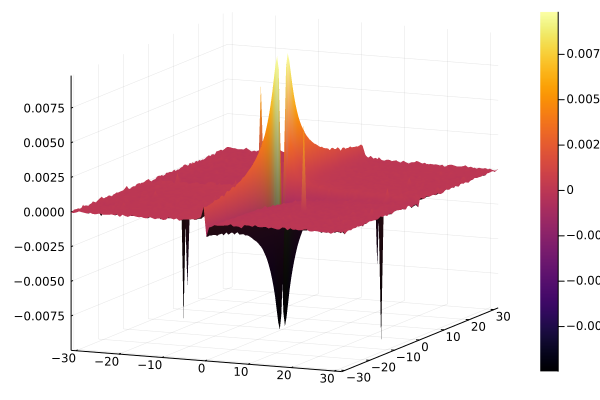

In [43]:
plot(ω3, ω3, real(transform3_cuhre), st=:surface)


In [26]:
using Cuba

function integrand(x, f)
    # Complex integrand, scaled to integrate in [0, 1].
    tmp = ℯ.^(im*2*(x[1]*β))
    # Assign to two components of "f" the real
    # and imaginary part of the integrand.
    f[1] = real(tmp)
    f[2] = imag(tmp)
end

result = cuhre(integrand, 2, 2)
println("Result of Cuba: ", result[1][1] + im*result[1][2])


function G_ABC_gl_part2(A, B, C, H, β, space, ω1, ω2)
    #return transpose(Δτ2*ℯ.^(im*ω2*transpose(τ_arr2))*transpose(Δτ1*ℯ.^(im*ω1*transpose(τ_arr1))*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)))
    function integrand(x, f)
        #temp=transpose(ℯ.^(im*ω2*transpose(x[2]*β))*transpose(ℯ.^(im*ω1*transpose(x[1]*β))
        #        *G_ABC(A,B,C,[x[1]*β],[x[2]*β],H,β,space,0.0)[1,1]))
        temp=ℯ.^(im*ω2*(x[2]*β))*ℯ.^(im*ω1*(x[1]*β))*G_ABC(A,B,C,[x[1]*β],[x[2]*β],H,β,space,0.0)[1,1]

        f[1],f[2]=reim(temp)
        #f[1]=im*x[1]
    end
    result, err = cuhre(integrand, 2, 2, atol=1e-3, rtol=1e-2);
    return complex(result[1],result[2])
end


@time begin
G_ABC_gl_part2(A3, B3, C3, H3, β3, space3, 2, 2)
end

Result of Cuba: 0.04564726252768001 + 0.02959589690344751im
  1.169965 seconds (3.87 M allocations: 453.978 MiB, 9.33% gc time, 16.37% compilation time)


0.00021602935771189088 - 0.0011550720569555313im

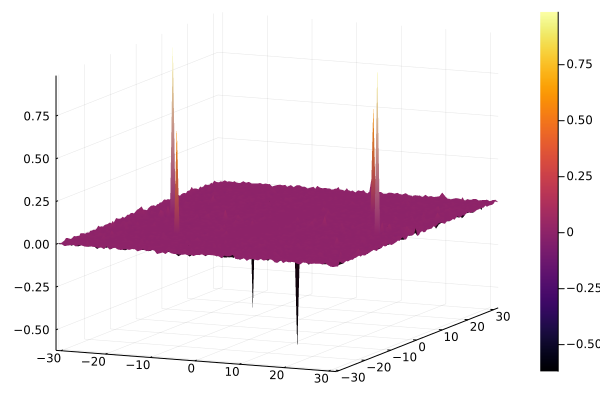

In [41]:
plot(ω3, ω3, transform3_Lehmann_real-100*real(transform3_cuhre), st=:surface)
# schnitte davon, diese punkte beobachten